In [1]:
import scatac
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
from multiprocessing import Pool

In [9]:
input_file = 'all_merge.sort.bam'
genome_name = 'hg38.chr.size'

idxList, idyList, countList, qc_dict = scatac.preProcess(input_file, genome_name)

with open('qc_dict.pydata','wb') as f1:
    pickle.dump(qc_dict, f1)

with open('idxList.pydata','wb') as f1:
    pickle.dump(idxList, f1)

with open('idyList.pydata','wb') as f1:
    pickle.dump(idyList, f1)

with open('countList.pydata','wb') as f1:
    pickle.dump(countList, f1)

25900000 tags, 1638.28 seconds
26000000 tags, 1646.29 seconds
26100000 tags, 1655.94 seconds
26200000 tags, 1665.74 seconds
26300000 tags, 1675.32 seconds


In [95]:
idxList = np.array(idxList)
idyList = np.array(idyList)
countList = np.array(countList)

countHighIdx = countList.argsort()[-(len(countList)//1000):][::-1]

In [96]:
countList = np.delete(countList, countHighIdx)
idxList = np.delete(idxList, countHighIdx)
idyList = np.delete(idyList, countHighIdx)

In [98]:
import collections
import math


bin_count_dict = collections.defaultdict(lambda: 0)
bin_count = []
bin_id = []

for i in idyList:
    bin_count_dict[i] += 1

for i in bin_count_dict.keys():
    norm_bin_count = math.log10(bin_count_dict[i]+1)
    # bin_count_dict[i] = norm_bin_count
    bin_count.append(norm_bin_count)
    bin_id.append(i)

We found the log-scaled coverage obey approximately a gaussian distribution which is then converted into zscore. Bins with zscore beyond ±2 were filtered before further analysis.

**log-scaled coverage obey approximately a gaussian distribution**

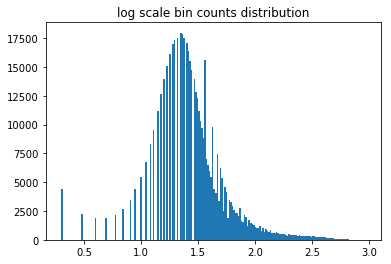

In [99]:
plt.hist(bin_count, bins=200)
plt.title('log scale bin counts distribution')
plt.show()

In [100]:
from scipy import stats

bin_count = np.array(bin_count)
bin_id = np.array(bin_id)
bin_zscore = stats.zscore(bin_count)
mask = (bin_zscore < -2) | (bin_zscore > 2)

**bin norm counts converted into zscore**

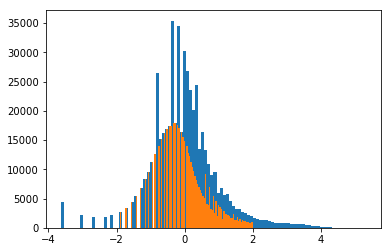

In [377]:
plt.hist(bin_zscore, bins=100)
plt.hist(bin_zscore[mask], bins=100)
plt.show()

In [101]:
barIdx = dict(list(zip(list(set(idyList)), range(len(set(idyList))))))
x = np.zeros((len(set(idxList)),len(set(idyList))), dtype='uint8')

In [102]:
for i in range(len(idyList)):
    x[idxList[i]-1][barIdx[idyList[i]]] = 1

In [103]:
x.shape

(1350, 526327)

In [104]:
rmbin_list = []
for i in bin_id[mask]:
    rmbin_list.append(barIdx[i])
len(rmbin_list)

31872

In [105]:
x = np.delete(x, rmbin_list, axis=1)
x.shape

(1350, 494455)

In [106]:
# save data
f1 = open('x.pydata','wb')
pickle.dump(x, f1)
f1.close()

In [6]:
# load data
f1 = open('x.pydata','rb')
x = pickle.load(f1)
f1.close()

In [ ]:
from sklearn.decomposition import PCA

pca = PCA().fit(x_filter)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [107]:
x_jac = np.zeros((len(x),len(x)))

### This is a single thread proccess, very slow!

In [ ]:
from sklearn.metrics import jaccard_score
n = 0
tt = time.time()
for i in range(len(x_filter)):
    for j in range(i, len(x_filter)):
        if i == j:
            x_jac[i][j], x_jac[j][i] = 1, 1
        else:
            x_jac[i][j] = jaccard_score(x_filter[i], x_filter[j])
            x_jac[j][i] = x_jac[i][j]
        n += 1
        if n % 1000 == 0:
            print(f'{n} tags, {time.time()-tt:.2f} seconds')

### This is the multiproccess, but not suit for large matrix due to RAM limition

In [ ]:
from sklearn.metrics import jaccard_score

def jaccard(args):
    return jaccard_score(args[0],args[1])

PROCESSES = 16
tt = time.time()
p = Pool(PROCESSES)
xx = ((x[i],x[j]) for i in range(len(x)) for j in range(i, len(x)))
tt = time.time()
res_list = p.map(jaccard, xx)
print(time.time() - tt)
del xx

n = 0
x_jac = np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(i, len(x)):
        x_jac[i][j] = res_list[n]
        x_jac[j][i] = res_list[n]
        n += 1
#del res_list

### optimation for the multiproccess

In [ ]:
from sklearn.metrics import jaccard_score

def jaccard(args):
    return jaccard_score(args[0],args[1])

PROCESSES = 20
p = Pool(PROCESSES)

xx = ((x[i],x[j]) for i in range(len(x)) for j in range(i, len(x)))

totalNum = (len(x)+1)*len(x)//2
jobs = []
res_list = []
tt = time.time()
n = 0

for job in xx:
    jobs.append(job)
    if len(jobs) == 1000:
        result = p.map(jaccard, jobs)
        res_list += result
        n += 1
        
        print(f'{n*1000/totalNum*100:.3f} %, {time.time()-tt:.2f} seconds')
        
        jobs.clear()
        del result

result = p.map(jaccard, jobs)
res_list += result

f1 = open('res_list.pydata','wb')
pickle.dump(res_list, f1)
f1.close()

#  convert res_list to Jaccard matrix
n = 0
x_jac = np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(i, len(x)):
        x_jac[i][j] = res_list[n]
        x_jac[j][i] = res_list[n]
        n += 1

In [109]:
res_list = np.array(res_list)
res_list[res_list == 1] = x_jac.mean()

### Jaccard index raw t-sne

In [111]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2).fit_transform(x_jac)

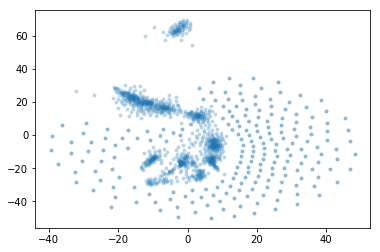

In [112]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, alpha=0.3, linewidths=0)
plt.show()

### Calculate the Expected Jaccard index matrix

In [113]:
exp_list = []
totalNum = (len(x)+1)*len(x)//2
bin_num = len(x[0])
idxList = np.array(idxList)

print('Start counting bins for each barcodes')
tt = time.time()
bin_counts = []
for i in range(len(x)):
    bin_counts.append(len(x[i][x[i]==1]))

n = 0
for i in range(len(x)):
    for j in range(i, len(x)):
        exp_list.append(1/(bin_num/bin_counts[i]+bin_num/bin_counts[j]-1))
        n += 1
        if n % 100000 == 0:
            print(f'{n/totalNum*100:.3f} %, {time.time()-tt:.2f} seconds')
        

Start counting bins for each barcodes
10.966 %, 6.76 seconds
21.932 %, 6.90 seconds
32.897 %, 7.04 seconds
43.863 %, 7.18 seconds
54.829 %, 7.32 seconds
65.795 %, 7.46 seconds
76.761 %, 7.60 seconds
87.727 %, 7.74 seconds
98.692 %, 7.89 seconds


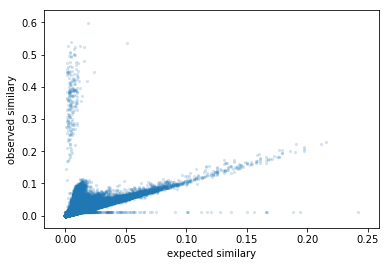

In [114]:
plt.scatter(exp_list, res_list, s=10, alpha=0.2, linewidths=0)
plt.xlabel('expected similary')
plt.ylabel('observed similary')
plt.show()

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

exp_list = np.array(exp_list)
res_list = np.array(res_list)
X_train, X_test, y_train, y_test = train_test_split(exp_list, res_list, test_size=0.33, random_state=42)
X_train = np.array(X_train).reshape(-1, 1)
tt = time.time()
print('Start training LinearRegression model')
reg = LinearRegression()
reg.fit(X_train, y_train)
print(f'{time.time()-tt:.2f} seconds, training finished!')
y_preds = reg.predict(exp_list.reshape(-1, 1))

residuals = res_list - y_preds

Start training LinearRegression model
0.06 seconds, training finished!


In [116]:
reg.score(X_train, y_train)

0.49701229090716426

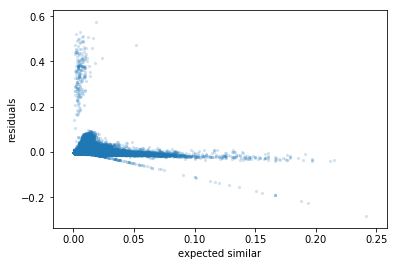

In [117]:
plt.scatter(exp_list, residuals, s=10, alpha=0.2, linewidths=0)
plt.xlabel('expected similar')
plt.ylabel('residuals')
plt.show()

In [118]:
n = 0
x_norm = np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(i, len(x)):
        x_norm[i][j] = residuals[n]
        x_norm[j][i] = residuals[n]
        n += 1

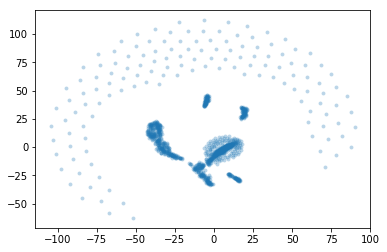

In [119]:
from sklearn.manifold import TSNE
X_tsne = TSNE(n_components=2).fit_transform(x_norm)


plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=15, alpha=0.3, linewidths=0)
plt.show()

In [466]:
genome_dict = scatac.readGenomeSizeFromTxt('hg38.chr.size')
bin_dict = scatac.getBinsFromGenomeSize(genome_dict, 5000)

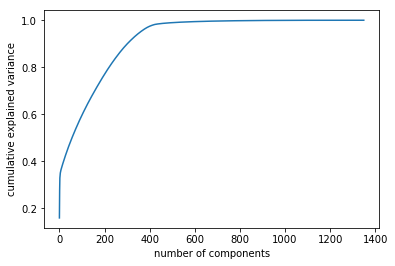

In [271]:
from sklearn.decomposition import PCA

pca = PCA().fit(x_norm)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [274]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
len(cumsum[cumsum < .9])

301

In [275]:
pca = PCA(n_components=301)
pca.fit(x_norm)
X_pca = pca.transform(x_norm)

In [470]:
X_pca.shape

(1350, 258)

In [123]:
import networkx as nx
from scipy.spatial import distance
import community


G = nx.Graph()
dis = []
with open('network.txt', 'w') as f:
    for i in range(len(X_pca)):
        for j in range(i+1, len(X_pca)):
            weight = distance.euclidean(X_pca[i], X_pca[j])
            dis.append(weight)
            G.add_edge(str(i), str(j), weight=weight)
            f.write(f'{i}\t{j}\t{weight}\n')
dis = np.array(dis)

In [124]:
partition = community.best_partition(G, resolution = 0.1)
len(set(partition.values()))

1350

In [563]:
X_pca.shape

(1350, 258)

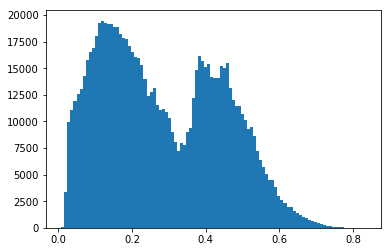

In [507]:
plt.hist(dis, bins=100)
plt.show()

In [68]:
from sklearn.metrics.pairwise import pairwise_distances
import kmedoids

D = pairwise_distances(X_pca, metric='euclidean')

M, C = kmedoids.kMedoids(D, 10)

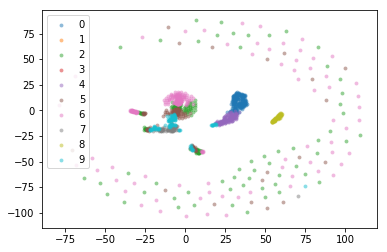

In [69]:
for key in C.keys():
    plt.scatter(X_tsne[C[key], 0], X_tsne[C[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.legend()
plt.show()

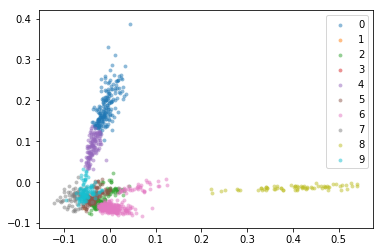

In [70]:
for key in C.keys():
    plt.scatter(X_pca[C[key], 0], X_pca[C[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.legend()
plt.show()

### Clustering

Created a cells by cells graph. Edge weight between any two cells are refined by shared overlap in their local neighborhoods using Jaccard similarity.

In [ ]:
G = nx.Graph()

for i in range(len(x_jac)):
    for j in range(i+1, len(x_jac)):
        #weight = distance.euclidean(X_pca[i], X_pca[j])
        #dis.append(weight)
        G.add_edge(str(i), str(j), weight = x_jac[i][j])

In [206]:
partition = community.best_partition(G, resolution=1)
part = collections.defaultdict(list)
for k,v in partition.items():
    part[v].append(int(k))

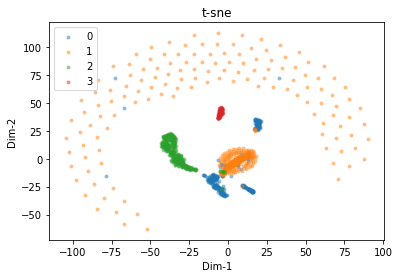

In [126]:
for key in part.keys():
    plt.scatter(X_tsne[part[key], 0], X_tsne[part[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.title('t-sne')
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.legend()
plt.show()

In [266]:
import umap

embedding = umap.UMAP(n_components=2, random_state=42).fit_transform(x_jac)

/public/home/mowp/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


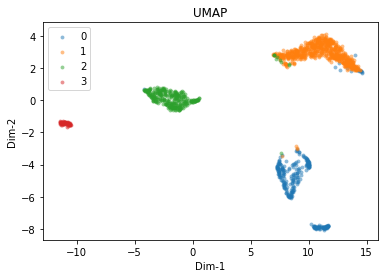

In [207]:
for key in part.keys():
    plt.scatter(embedding[part[key], 0], embedding[part[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.title('UMAP')
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.legend()
plt.show()

In [137]:
partition = community.best_partition(G, resolution=0.9)
part = collections.defaultdict(list)
for k,v in partition.items():
    part[v].append(int(k))

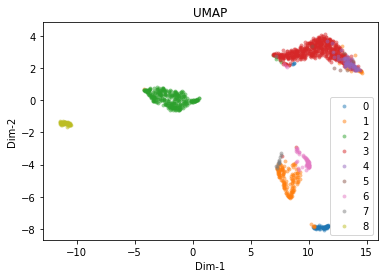

In [205]:
for key in part.keys():
    plt.scatter(embedding[part[key], 0], embedding[part[key], 1], s=15, alpha=0.5, linewidths=0, label=key)

plt.title('UMAP')
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.legend()
plt.show()

### Clustering by K-NN

created a k-nearest neighbor graph in which every cell is represented as a node and edges are drawn between cells within k nearest neighbors. Edge weight between any two cells are refined by shared overlap in their local neighborhoods using Jaccard similarity

In [293]:
from sklearn.neighbors import NearestNeighbors

nbrs = NearestNeighbors(n_neighbors=15, metric='euclidean').fit(x_jac)
distances, indices = nbrs.kneighbors(x_jac)

In [294]:
G = nx.Graph()

for indice in indices:
    for i in range(len(indice)):
        for j in range(i+1, len(indice)):
            G.add_edge(str(indice[i]), str(indice[j]), weight = x_jac[indice[i]][indice[j]])

In [295]:
partition = community.best_partition(G, resolution=1)
part = collections.defaultdict(list)
for k,v in partition.items():
    part[v].append(int(k))

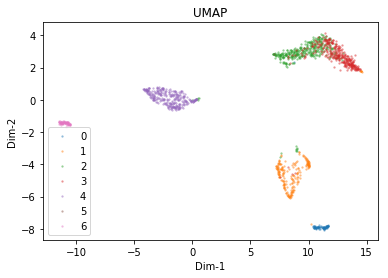

In [296]:
for key in part.keys():
    plt.scatter(embedding[part[key], 0], embedding[part[key], 1], s=5, alpha=0.5, linewidths=0, label=key)

plt.title('UMAP')
plt.xlabel('Dim-1')
plt.ylabel('Dim-2')
plt.legend()
plt.show()

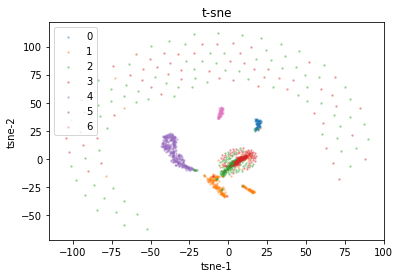

In [297]:
for key in part.keys():
    plt.scatter(X_tsne[part[key], 0], X_tsne[part[key], 1], s=5, alpha=0.5, linewidths=0, label=key)

plt.title('t-sne')
plt.xlabel('tsne-1')
plt.ylabel('tsne-2')
plt.legend()
plt.show()